# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded 
by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [20]:
%matplotlib inline                                                                                                                                      
import csv 
import cv2 
import glob
import os
import pickle
import time
import urllib.request
import zipfile

import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf

from scipy.misc import imresize       
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

if not os.path.isfile('train.p'):
    print('Downloading data set...')
    urllib.request.urlretrieve(
        'https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip',
        'traffic-signs-data.zip'
    )
    print('Extracting...')
    with zipfile.ZipFile('traffic-signs-data.zip', 'r') as z:
        z.extractall()
    print('Done!')

In [41]:
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [42]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(x_train)

# TODO: Number of testing examples.
n_test = len(x_test)

# TODO: What's the shape of an traffic sign image?
image_shape = x_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

print(len(x_train))
print(len(y_train))

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
34799
34799


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery]
(http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

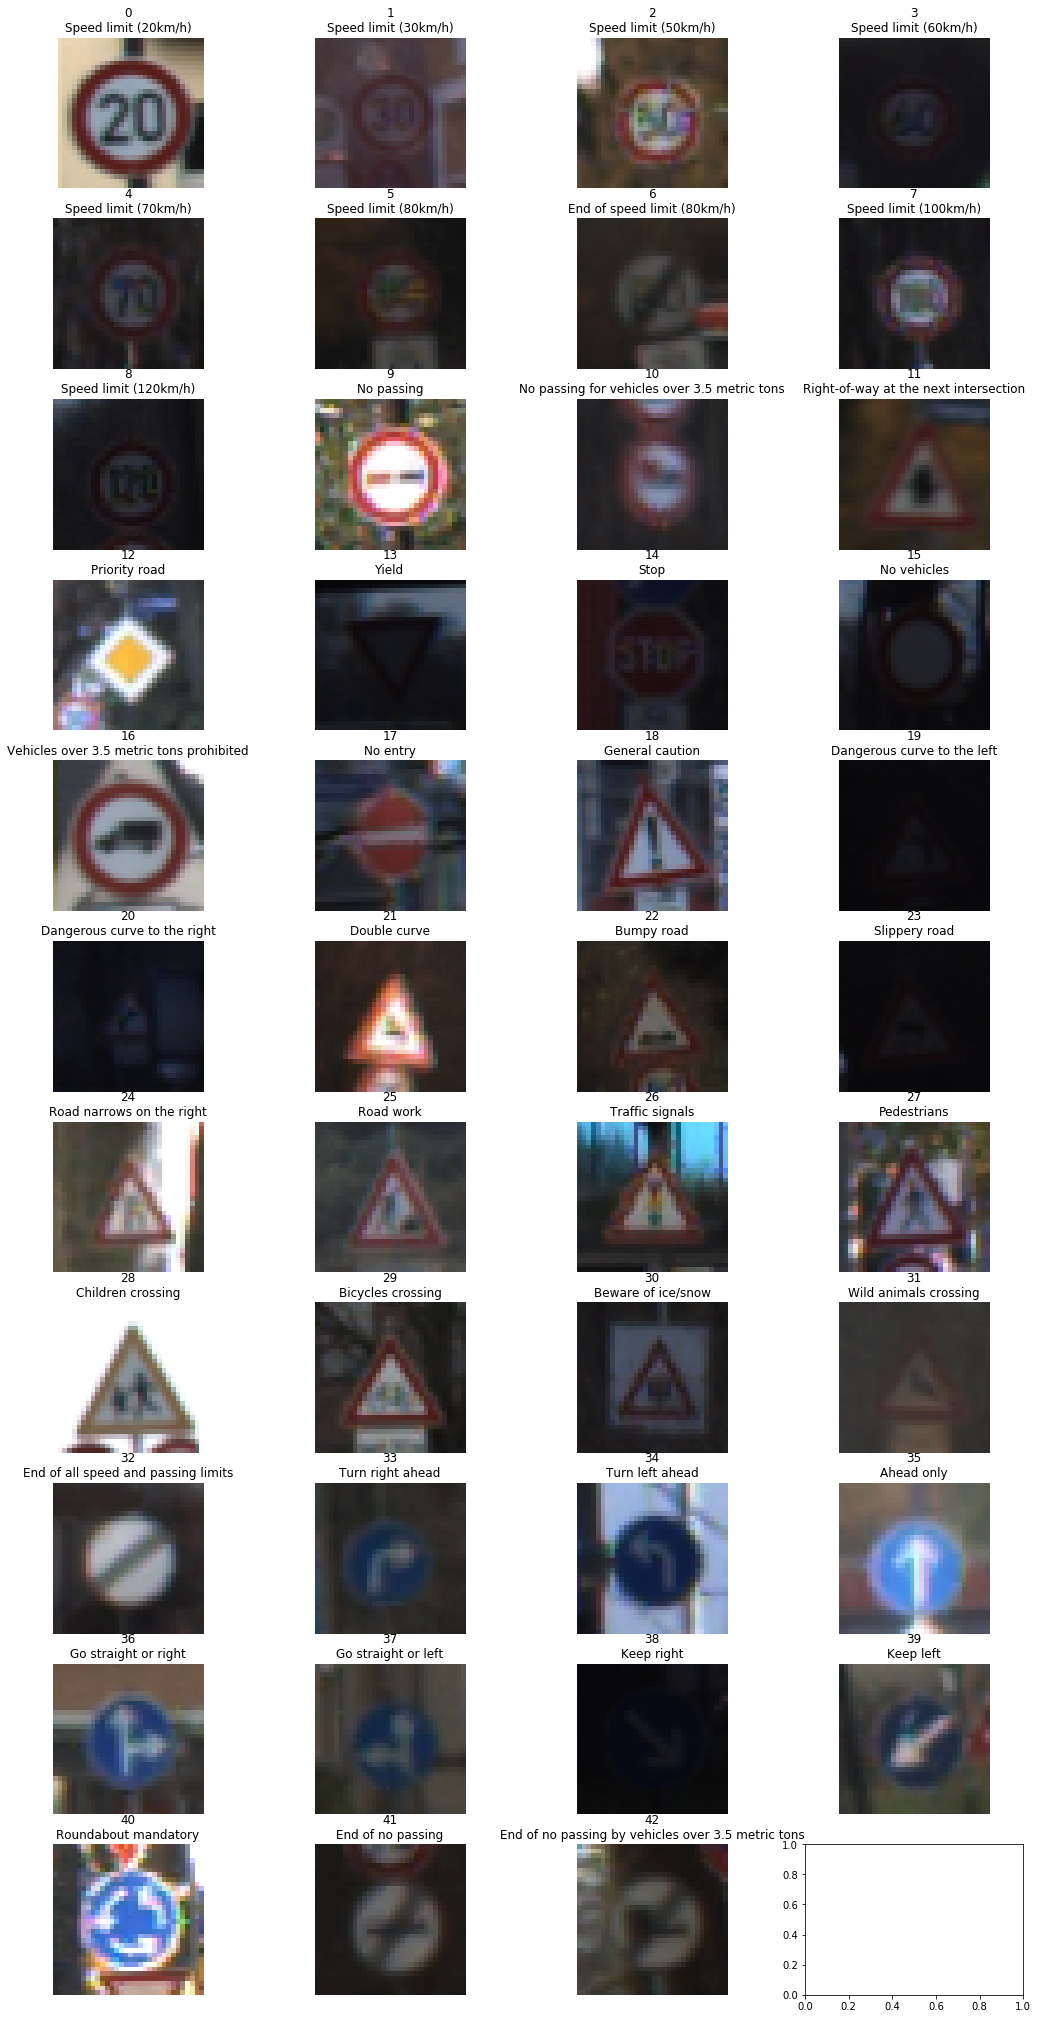

In [43]:
sign_label_mapping = {}

with open("signnames.csv") as fh:
    reader = list(csv.reader(fh))
    sign_label_mapping = {int(k): v for k, v in reader[1:]}

# figure out where in the x_train list certain images are located. They are unordered
# so go through everything and find examples of where each type of image is located
# in the list
image_type_indices = []

image_types = set()
for i, label_num in enumerate(y_train):
    if label_num not in image_types:
        image_type_indices.append((i, label_num))
        image_types.add(label_num)

# sort by the image type...the two element tuples are of the form:
#  (index, image_label_type)
#
image_type_indices.sort(key=lambda t: t[1])

fig, axes = plt.subplots(11, 4, figsize=(18, 36))

for index, image_num in image_type_indices:
    img = x_train[index]
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #img[:,:,2] = [[max(pixel - 25, 0) if pixel < 190 else min(pixel + 25, 255) \ 
    #     for pixel in row] for row in img[:,:,2]]
    #img = augment_brightness_camera_images(img)
    axes.flat[image_num].imshow(img, cmap='hsv')
    axes.flat[image_num].axis('off')
    axes.flat[image_num].set_title(
        str(image_num) + "\n" + sign_label_mapping[image_num], 
        fontsize=12)

## To add rotated images....
```


def rotate_image(img, degrees):
    rows, cols = img.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2,rows / 2), degrees, 1)
    return cv2.warpAffine(img, M, (cols, rows))


# take a look at rotating images.
img = x_train[4]

left_image = rotate_image(img, 20)
right_image = rotate_image(img, -20)

plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(left_image)
plt.subplot(133)
plt.imshow(right_image)


rotated_images = []
rotated_labels = []
for i, img in enumerate(x_train):
    l = rotate_image(img, 20)
    r = rotate_image(img, -20)
    rotated_images.extend([l, r])
    rotated_labels.extend([y_train[i], y_train[i]])
    
 # build up all our training data
#all_training = np.append(x_train, rotated_images, axis=0)
#all_labels = np.append(y_train, rotated_labels)

```

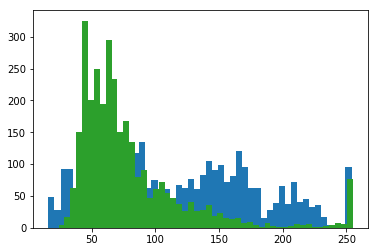

In [31]:
for index, num in image_type_indices[:3]:
    img = x_train[index]
    flat = img.flatten()
    plt.hist(flat, bins=50)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [44]:
x_train, y_train = shuffle(x_train, x_train)

print(len(x_train[1]))

32


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I used the `shuffle` method from sklearn which was lifted from the example solution.  Shuffling randomly is usually pretty good in most situations where you need to mix up the data ordering.

In [45]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
print(n_test)

# take 20% of the images for validation
num_validation_images = int(n_test * 0.2)

print(len(x_test))
x_validation, y_validation = x_test[:num_validation_images], y_test[:num_validation_images]

x_test = x_test[num_validation_images:]
y_test = y_test[num_validation_images:]

print("Number of validation images:", num_validation_images)
print("New number of testing images:", len(x_test), len(y_test))

12630
12630
Number of validation images: 2526
New number of testing images: 10104 10104


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

Pretty simple...just too 20% of the testing images and reserved them for validation.

In [46]:
### Define your architecture here.
### Feel free to use as many code cells as needed.


def GermanSigns(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    # changed input size from 32x32x1 to 32x32x3
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # print(conv1)
    
    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #print(conv2)
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # print(conv2)

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    #print("fc0", fc0)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    #print("fc1", fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    #print("fc2", fc2)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    #print("logits", logits)
    
    return logits
    

print("Num training images:", n_train)
print("Num validation images:", len(x_validation))
print("Num test images:", n_test)

Num training images: 34799
Num validation images: 2526
Num test images: 12630


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

This is fully lifted from the LeNet architecture. I use an `AdamOptimizer` with the following parameters:

- Learning rate &rarr; `0.001`
- Epochs &rarr; 30
- Batch size &rarr; 64

I updated parameters accordingly to take into account 3 layers in the input for the RGB channels.

- Please discuss how did you choose the optimzer. (Missed Answer)
- Please discuss how did you tell a convolutional layer is well suited for this problem. (Missed Answer)
- Please discuss how did you choose the particular activation (Missed Answer)
- Please discuss how did you tune the hyperparameter. (Missed Answer)

In [50]:
x = tf.placeholder(tf.float32, (None, ) + image_shape)
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.001

name = str(int(time.time()))

logits = GermanSigns(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

EPOCHS = 3
BATCH_SIZE = 64

saver = tf.train.Saver()

def evaluate(x_data, y_data):
    num_examples = len(x_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = x_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [51]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        x_train, y_train = shuffle(x_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(x_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './trafficsigns')
    print("Model saved")

Training...



InvalidArgumentError: logits and labels must be same size: logits_size=[64,43] labels_size=[196608,43]
	 [[Node: SoftmaxCrossEntropyWithLogits_3 = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_9, Reshape_10)]]

Caused by op 'SoftmaxCrossEntropyWithLogits_3', defined at:
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-50-5d7e5101601d>", line 10, in <module>
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 1449, in softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 2265, in _softmax_cross_entropy_with_logits
    features=features, labels=labels, name=name)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): logits and labels must be same size: logits_size=[64,43] labels_size=[196608,43]
	 [[Node: SoftmaxCrossEntropyWithLogits_3 = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_9, Reshape_10)]]


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** 

I used the same training as in the LeNet architecture. I did play with the training rate, epoch and batch size a bit.  I found that increasing the epochs and lowering the batch size by 1/2 produced better accuracy than the original values.  I also found that increasing the larning rate led to worse accuracy.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

Mainly this was trial and error.  I would have loved to have experimented with different CNN designs but just didn't have the time to go through that process.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
def test_on_test_data():
    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph('trafficsigns.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('./'))
        test_accuracy = evaluate(x_test, y_test)
        print("Test Accuracy = {:.3f}".format(test_accuracy))

test_on_test_data()

## Take a look at the new images

In [ ]:
files = sorted(glob.glob("street-signs/*"))

include_training_image = False

# the expected image category index is embedded into the file name...grep that out
expected_indices = [int(fn.split('-')[-1].strip('.jpg').lstrip('indx')) for fn in files]

# load up the new images and resize/process
images = [plt.imread(fn) for fn in files]
images = [imresize(img, [32, 32, 3]) for img in images]

# optionally included one of the trained images to ensure it results in a hit, making
# the accuracy go up...just a sanity check for the testing code below.
if include_training_image:
    expected_indices.append(y_train[0])
    images.append(x_train[0])

expected_indices = np.array(expected_indices)

In [ ]:
n = 14
rows, cols = (4, 3)

fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
fig.tight_layout()

r, c = (0, 0)
for i, img in enumerate(images):
    if c > cols - 1:
        c = 0
        r += 1

    ax = axes[r][c]
    ax.imshow(img)
    ax.set_title(str(expected_indices[i]) + " - " + sign_label_mapping[expected_indices[i]])
    ax.axis('off')
    
    c += 1

In [ ]:
print(expected_indices)

In [ ]:
import glob
import numpy as np


with tf.Session() as sess:
    test_saver = tf.train.import_meta_graph('trafficsigns.meta')
    test_saver.restore(sess, tf.train.latest_checkpoint('./'))
    real_test_accuracy = evaluate(images, expected_indices)
    print("Test Accuracy = {:.3f}".format(real_test_accuracy))

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

It looks like the testing on different images did so-so with accuraccy of only 50%.  I think some of this could be due to the relatively poor image quality from the training set.  I noticed the training set images looks a lot more blurry and washed out compared to the images i found on the web.  Some of my images were at different angles which could have thrown the model for a loop.

In [ ]:
# Let's take a look at which new images were classified correctly

with tf.Session() as sess:
    s = tf.train.import_meta_graph('trafficsigns.meta')
    s.restore(sess, tf.train.latest_checkpoint('./'))
    for i in range(len(images)):
        result = sess.run(
            accuracy_operation,
            feed_dict={x: images[i:i+1], y: expected_indices[i:i+1]}
        )
        match = 'YES' if result else 'NO '
        print(match, files[i])

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

In [ ]:
softmax_out = tf.nn.softmax(logits)

with tf.Session() as sess:
    s = tf.train.import_meta_graph('trafficsigns.meta')
    s.restore(sess, tf.train.latest_checkpoint('./'))
    softmax_prob = sess.run(softmax_out, feed_dict={x: images})

In [ ]:
with tf.Session() as sess:
    result = sess.run(tf.nn.top_k(tf.constant(softmax_prob), k=3))

In [ ]:
correct = 0
in_top = 0

for i, top_picks in enumerate(result.indices):
    e = expected_indices[i]
    was_correct = e == top_picks[0]
    prediction_in_top = e in top_picks
    if was_correct:
        correct += 1
    if prediction_in_top:
        in_top += 1
        
print("Num correct: %s, accuracy: %0.3f" % (correct, correct / len(images)))
print("Number of images in top picks: %s, possible accuracy %0.3f" % (in_top, in_top / len(images)))

In [ ]:
probs = result.values.flatten()
probs = sorted(probs)

fig, (h, l) = plt.subplots(1, 2, figsize=(14, 6))
h.hist(probs, bins=25)
l.plot(probs)


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.